# `Neural-Prophet` Machine Learning Model Documentation



# **Neural Prophet Parameters**
### ******Input Parameters from Interface******

In [ ]:
# NeuralProphet

growth='linear'  #Literal['off', 'linear', 'discontinuous']

changepoints= None #  []    #Optional[list]
n_changepoints =None     #0, #int
changepoints_range=None     #0.8 #float

#To Control Seasonality
yearly_seasonality= False     #'auto'
weekly_seasonality= False     #'auto'
daily_seasonality = False     #'auto'

seasonality_mode='additive' #['additive', 'multiplicative']
seasonality_reg= None    #float 0


confidence_lv = 0.9
#quantiles  = None      # []   #List[float]
quantiles = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)]


impute_missing= None,  #bool
impute_linear = None,  #int
impute_rolling= None,  #int
drop_missing  = None   #bool
normalize=None      #'off'       # Literal['auto', 'soft', 'soft1', 'minmax', 'standardize', 'off']

n_lags=None        #0    # int 0
n_forecasts=None   #0 #int 1

ar_layers=None   #[]    #Optional[list]
ar_reg= None       #Optional[float]
lagged_reg_layers= None    #[]   #Optional[list]
learning_rate= None   #Optional[float]


epochs= None       #Optional[int]
batch_size= None   #Optional[int]
loss_func=None  #'Huber'
optimizer=None  #'AdamW'

season_global_local=None #['global', 'local']

trend_reg= None  #Optional[float]
trend_reg_threshold =None  #Optional[Union[bool, float]]
trend_global_local= None   #str 'global', 'local'

newer_samples_weight= None  # float
newer_samples_start =None   #float

collect_metrics= None      #Union [bool, list, dict]

global_normalization=None
global_time_normalization=None
unknown_data_normalization=None

accelerator=None  #Optional[str] None
trainer_config=None # dict {},
prediction_frequency=None  # Optional[dict]

In [ ]:
#Additional  Seasonality regressors

#Custom holidays
country_name='SA' # Country Code  (ISO 3166-2) for holidayss


yearly_add_seasonality=False
yearly_season_period=None
yearly_season_fourier_order=None

quarterly_add_seasonality=False
quarterly_season_period=None
quarterly_season_fourier_order=None

monthly_add_seasonality=False
monthly_season_period=None
monthly_season_fourier_order=None

# Weekend days (0-6, Mon-Sun)
weekend_days = [4]  # 4 is Friday

Weekend_add_seasonality=True
weekendDaysCount=1
Weekends_fourier_order=15

WorkingDays_add_seasonality=True
workingDaysCount=6
WorkingDays_fourier_order=5

ramadan_add_seasonality=True
ramadan_period=29.33
ramadan_fourier_order=10


In [ ]:
# Create a Prophet model with flexible parameters
prophet_params = {
'growth':'linear',
'changepoints':None,
'n_changepoints':None,
'changepoints_range':None,

'yearly_seasonality':False,
'weekly_seasonality':False,
'daily_seasonality':False,

'seasonality_mode':'multiplicative',
'seasonality_reg':None,

'quantiles':None,

'impute_missing':None,
'impute_linear':None,
'impute_rolling':None,
'drop_missing':None,
'normalize':None,

'n_lags':None,
'n_forecasts':None,

'ar_layers':None,
'ar_reg':None,
'lagged_reg_layers':None,
'learning_rate':None,

'epochs':None,
'batch_size':None,
'loss_func':None,
'optimizer':None,

'season_global_local':None,

'trend_reg':None,
'trend_reg_threshold':None,
'trend_global_local':None,

'newer_samples_weight':None,
'newer_samples_start':None,

'collect_metrics':None,

'global_normalization':None,
'global_time_normalization':None,
'unknown_data_normalization':None,

'accelerator':None,
'trainer_config':None,
'prediction_frequency':None

}
print(prophet_params)
# Remove parameters with value None
prophet_params = {key: value for key, value in prophet_params.items() if value is not None}
print(prophet_params)

# ****Prophet Algorithm****

### ****Importing Libraries****

In [ ]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import numpy as np

import logging
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
import ruptures as rpt
import warnings
import holidays
from hijri_converter import convert
from datetime import date,datetime, timedelta
from prophet.diagnostics import performance_metrics, cross_validation
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

### ****Importing the dataset****

In [ ]:
# Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'y'})  # Rename columns for Prophet compatibility
data = data[['ds', 'y']]
data['ds']=pd.to_datetime(data['ds'])

#Copy the dataframe data
data_copy = data.copy()


# # Define the start and end dates for filtering covid  
covid_start_date = '2020-03-02'
covid_end_date = '2020-06-21'

# Filter the data frame to include only the year 2023
#data = data[data['ds'].dt.year ==2023]

# Get the first and last dates of the filtered data
start_date = pd.to_datetime( data['ds'].iloc[0])
end_date = pd.to_datetime( data['ds'].iloc[-1])

# Extract the first 30 days of the data
first_30Days = data.iloc[0:30]

data.head(2)
#plt = data.plot(x="ds", y="y", figsize=(15, 5))

## Generate Ramadan Dates

The function generate_ramadan_dates_df(start_year, end_year) generates a DataFrame of Ramadan dates in the Gregorian calendar for a given range of years.

In [ ]:
def generate_ramadan_dates_df(start_year, end_year):
    ramadan_dates = []

    for year in range(start_year, end_year + 1):
        # The Umm al-Qura calendar uses Hijri dates for Islamic months
        hijri_year_start = convert.Gregorian(year, 1, 1).to_hijri()
        hijri_year_end = convert.Gregorian(year, 12, 30).to_hijri()

        for day in range(1, 30):  # Assuming Ramadan lasts for 29 or 30 days
            # Find the date of Ramadan in the Hijri calendar
            ramadan_date = convert.Hijri(hijri_year_start.year, 9, day).to_gregorian()

            # Append the date to the list
            ramadan_dates.append(ramadan_date)

    # Create a DataFrame with a column named 'ramadan_dates'
    ramadan_df = pd.DataFrame({'ds': ramadan_dates})
    return ramadan_df

start_year = start_date.year
end_year = end_date.year
ramadan_df = generate_ramadan_dates_df(start_year, end_year)

#### Adding  Ramadan dates in prophet Training Data
data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)
data.head(2)

## Generate the Weekend Days Param

In [ ]:
def generate_weekends(start_date, end_date, weekend_days):
    '''
    This function will generate weekends dataframe with ds and holiday columns
    Parameters : 
    start_date : start date of the data of type datetime
    end_date : end date of the data of type datetime
    weekend_days : list of weekend days ex: [4] for Friday
    return : weekends dataframe with ds and holiday columns
    '''
    weekends = []
    current_date = start_date
    while current_date <= end_date:
        # Check if the current date is a weekend
        if current_date.weekday() in weekend_days:
            weekends.append(current_date)
        current_date += timedelta(days=1)

    # Create a DataFrame with day names and dates
    weekend_df = {'ds': weekends,
                  'holiday': [day.strftime('%A') for day in weekends]}

    df_weekends = pd.DataFrame(weekend_df)
    return df_weekends
#print(type(start_date))
df_weekends = generate_weekends(start_date, end_date, weekend_days)
if Weekend_add_seasonality:
    data['is_weekend'] = data['ds'].isin(df_weekends['ds']).astype(int)  
if WorkingDays_add_seasonality:
    data['is_weekday'] = (data['is_weekend'] == 0).astype(int)
data.head(2)

In [ ]:
 
weekendDaysCount= len(weekend_days)
workingDaysCount= 7 - weekendDaysCount

first_30Days['is_weekend'] = first_30Days['ds'].isin(df_weekends['ds']).astype(int)
onlyWeekends= first_30Days[data['is_weekend']==1]

plt.plot(first_30Days['ds'],first_30Days['y'])
plt.scatter(onlyWeekends['ds'],onlyWeekends['y'], marker='v', color='r')
#increase the width of the plot
fig = plt.gcf()
fig.set_size_inches(15, 5)

data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)

# **Training Model**

#### ****Initialize the Model**** ####

In [ ]:
model = NeuralProphet (**prophet_params)

In [ ]:
data.head(2)

### ****Custom  Seasonalties****

In [ ]:
#Custom seasonality
#if the  passed condition is True or Not none then it  execute the below code
#Check the names of the variables from the variables

if country_name:
    model.add_country_holidays(country_name=country_name)

if yearly_add_seasonality:
    model.add_seasonality(name='yearly_season' ,period=yearly_season_period ,fourier_order=yearly_season_fourier_order )

if quarterly_add_seasonality:
    model.add_seasonality(name='quarterly_season' ,period=quarterly_season_period ,fourier_order=quarterly_season_fourier_order )

if monthly_add_seasonality:
    model.add_seasonality(name='monthly_season' ,period=monthly_season_period ,fourier_order=monthly_season_fourier_order )

if Weekend_add_seasonality:
    model.add_seasonality(name='Weekends_season' ,period=weekendDaysCount ,fourier_order=Weekends_fourier_order ,condition_name="is_weekend")

if WorkingDays_add_seasonality:
    model.add_seasonality(name='WorkingDays_season' ,period=workingDaysCount ,fourier_order=WorkingDays_fourier_order ,condition_name="is_weekday")

if ramadan_add_seasonality:
    model.add_seasonality(name='ramadan_season' ,period=ramadan_period ,fourier_order=ramadan_fourier_order ,condition_name="is_ramadan")

#### ****Fit the model to the data**** ####

In [54]:
# Use static plotly in notebooks
model.set_plotting_backend("plotly-static")
model.fit(data)

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,309067.125000,377819.250000,1.294967,0.0,0
1,233220.250000,285809.468750,0.946342,0.0,1
2,171030.375000,206438.406250,0.662336,0.0,2
3,110252.609375,133239.203125,0.381659,0.0,3
4,60468.222656,80597.242188,0.166711,0.0,4
...,...,...,...,...,...
152,25077.611328,38049.265625,0.047314,0.0,152
153,25056.636719,37941.203125,0.047310,0.0,153
154,25048.291016,37974.980469,0.047420,0.0,154
155,25064.521484,37886.675781,0.047505,0.0,155


## Generate future Dataframe Dates

In [55]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = model.make_future_dataframe(data, n_historic_predictions=True, periods=30)
 # Predict the future
forecast = model.predict(df_future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.951% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.952% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.952% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 30 rows at the end with NaNs in 'y' column.


Predicting: 32it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


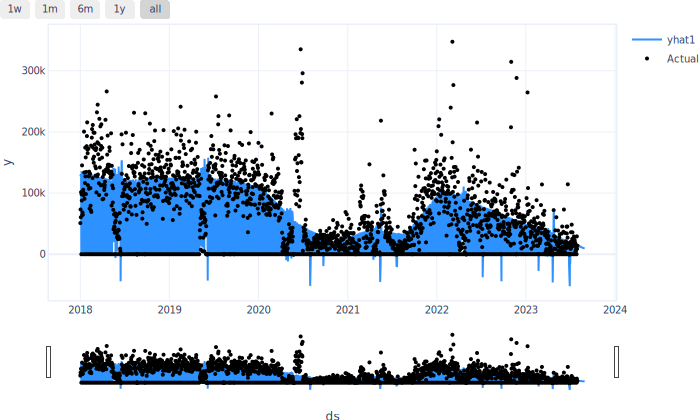

In [56]:
# Visualize the forecast
model.plot(forecast)

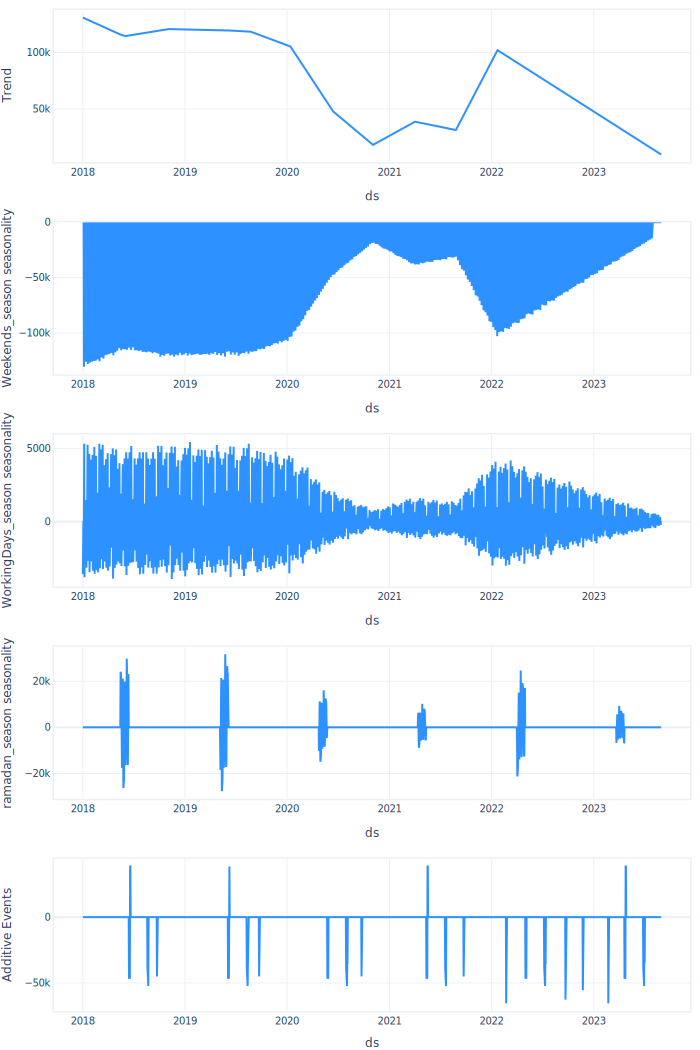

In [57]:
model.plot_components(forecast)

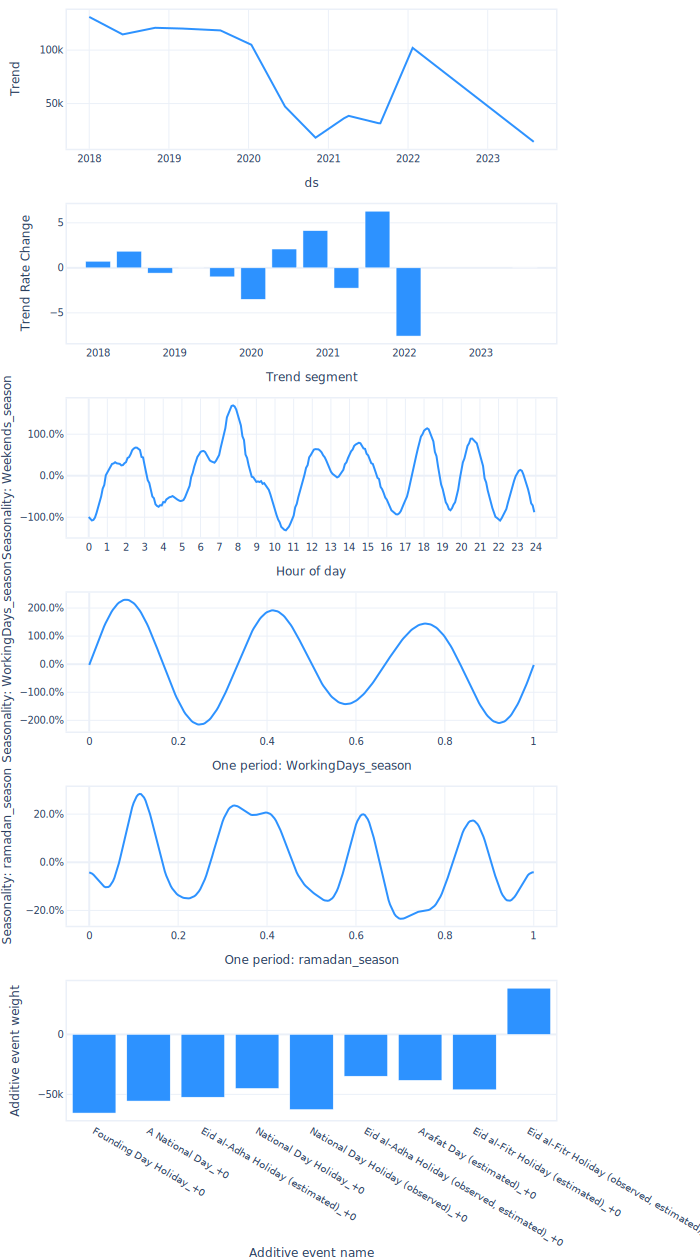

In [58]:
model.plot_parameters()

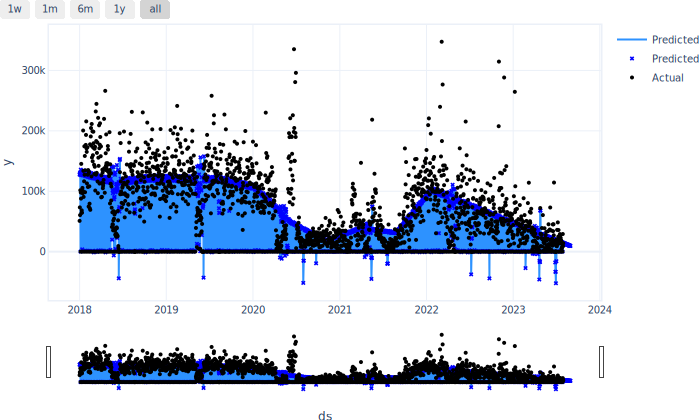

In [59]:
model.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)

In [60]:
#last 30 days of the forecast
forecast.tail(2)


,ds,y,yhat1,trend,season_Weekends_season,season_WorkingDays_season,season_ramadan_season,events_additive,event_A National Day,event_Arafat Day (estimated),event_Eid al-Adha Holiday (estimated),"event_Eid al-Adha Holiday (observed, estimated)",event_Eid al-Fitr Holiday (estimated),"event_Eid al-Fitr Holiday (observed, estimated)",event_Founding Day Holiday,event_National Day Holiday,event_National Day Holiday (observed)
2066,2023-08-29,NaN,9637.442383,9653.074219,0.0,-15.632247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2067,2023-08-30,NaN,9447.243164,9494.773438,0.0,-47.530415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comparision of actual data and forecasted data

In [61]:
actualdata = pd.read_csv('/home/ajaz/DemandForecasting/Data/actualdata.csv')
actualdata = actualdata.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'actual'})
actualdata['ds']=pd.to_datetime(actualdata['ds'])
forecast = forecast[['ds','yhat1']].tail(30)

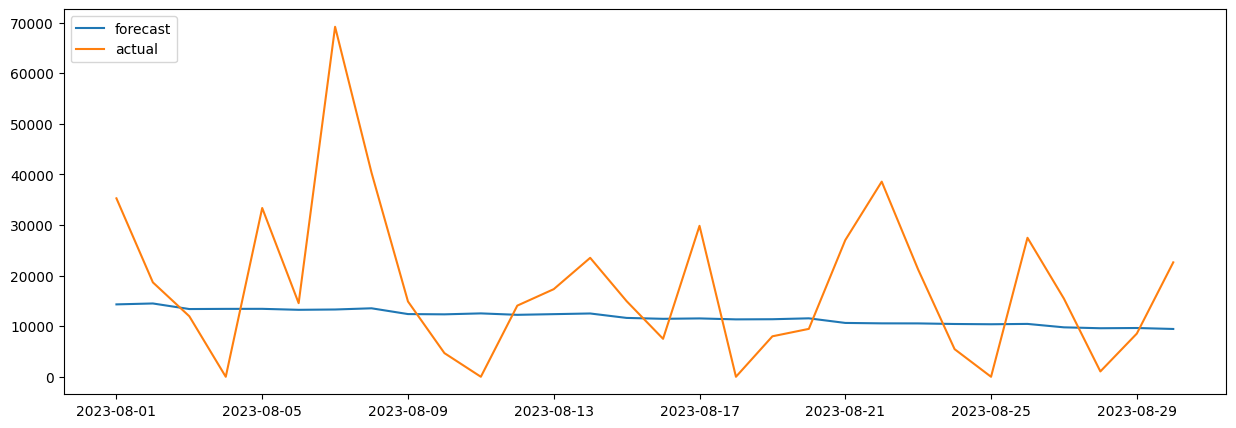

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(forecast['ds'], forecast['yhat1'], label='forecast')
ax.plot(actualdata['ds'], actualdata['actual'], label='actual')
ax.legend(loc='upper left')

plt.show()

## Validation and Reproducibility

df_train, df_val = model.split_df(data_copy, valid_p=0.2)

print("Dataset size:", len(df))
print("Train dataset size:", len(df_train))
print("Validation dataset size:", len(df_val))

metrics = model.fit(df_train, validation_df=df_val, progress=None)
metrics